In [1]:
!pwd

/home/giakhang/dev/RDPN6D


In [1]:
import cv2
import torch
import os
import os.path as osp
from pathlib import Path
from tqdm import tqdm
import trimesh
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
import time
import itertools

from detectron2.data import detection_utils as utils
from detectron2.structures import BoxMode
from detectron2.config import LazyConfig, instantiate
from detectron2.data import MetadataCatalog, get_detection_dataset_dicts
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

from core.gdrn_modeling.dataset_factory import register_datasets_in_cfg
from core.utils.draw_utils import *
from core.gdrn_modeling.engine_utils import batch_data
from lib.pysixd import inout, misc
from preprocess_utils import *
from data_utils import (
    read_image_cv2, crop_resize_by_warp_affine, my_warp_affine, get_2d_coord_np
)
from trt_infer import TensorRTInfer

from core.gdrn_modeling.models.pose_from_pred_centroid_z import pose_from_pred_centroid_z

/home/giakhang/miniconda3/envs/rdpn6d/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
config_path = "./configs/gdrn/a6_cPnP.py"
cfg = LazyConfig.load(config_path)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
engine_path = "./engine.trt"
trt_infer = TensorRTInfer(engine_path)

In [4]:
start_time = time.time()

src_dir = Path("./datasets/lumi_piano_dataset/data")
des_dir = Path("./results_correct/lumi_piano_datset")

os.makedirs(str(des_dir), exist_ok=True)

track_start = 1
track_end = 7
cls_id = 0

cad_path = "./datasets/lumi_piano_dataset/models/obj_000001.ply"
mesh = trimesh.load(cad_path)
mesh = mesh.sample(1024).astype(np.float32)

num_fps_points = cfg.model.rot_head_net.num_regions
objects = [
    "lumi_piano"
]

id2obj = {
    1: "lumi_piano"
}
obj2id = {_name: _id for _id, _name in id2obj.items()}

fps_points_path = "/home/giakhang/dev/RDPN6D/datasets/lumi_piano_dataset/models/fps_points.pkl"
fps_points = get_fps_points(num_fps_points, fps_points_path, objects, obj2id)[cls_id]

model_dir = "/home/giakhang/dev/RDPN6D/datasets/lumi_piano_dataset/models"
vertex_scale = 1
roi_extent = get_extents(objects, obj2id, model_dir, vertex_scale)[cls_id]

input_res = cfg.dataset_common_cfg.input_res 
out_res = cfg.model.backbone_out_res
dzi_pad_scale = cfg.dataset_common_cfg.dzi_pad_scale

num_imgs = 0

for track_id in range(track_start, track_end + 1):
    ann_file = src_dir / f"track_{track_id:02d}/image_set/lumi_piano_test.txt"
    des_track_dir = des_dir / f"track_{track_id:02d}"
    drawed_img_dir = des_track_dir / "vis_img"

    os.makedirs(str(des_track_dir), exist_ok=True)
    os.makedirs(str(drawed_img_dir), exist_ok=True)

    with open(str(ann_file), 'r') as f_ann:
        indices = [line.strip("\r\n") for line in f_ann.readlines()]  # string ids

    pred_info_path = des_track_dir / "scene_gt_info.json"
    pred_6d_path = des_track_dir / "scene_gt.json"
    pred_info = {}
    pred_6d = {}

    for im_id in tqdm(indices):
        num_imgs += 1
        int_im_id = int(im_id)

        img_path = src_dir / f"track_{track_id:02d}/rgb/{int_im_id:05d}.png"
        depth_path = src_dir / f"track_{track_id:02d}/depth/{int_im_id:05d}.png"
        cam_info_path = src_dir / f"track_{track_id:02d}/scene_camera.json"
        mask_path = src_dir / f"track_{track_id:02d}/scene_gt_info.json"

        with open(mask_path, 'r') as f:
            mask = json.load(f)
        with open(cam_info_path, 'r') as f:
            cam_dict = json.load(f)

        image = read_image_cv2(str(img_path), "BGR")
        drawed_img = image.copy()

        im_H, im_W = image_shape = image.shape[:2]  # h, w
        K = np.array(cam_dict[f"{str(int_im_id)}"]["cam_K"], dtype=np.float32).reshape(3, 3)
        coord_2d = get_2d_coord_np(im_W, im_H, low=0, high=1).transpose(1, 2, 0)
        bbox_key = "bbox"
        depth_img = np.array(Image.open(depth_path)).astype(np.float32)

        depth_img = depth_img / 1e3
        depth_img = depth_img[:, :, np.newaxis]

        img_mask_info = mask[str(int_im_id)]
        num_rois = len(img_mask_info)

        for roi_idx in range(num_rois):
            bbox = BoxMode.convert(img_mask_info[roi_idx]["bbox_visib"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            x1, y1, x2, y2 = bbox

            bbox_center = np.array([0.5 * (x1 + x2), 0.5 * (y1 + y2)])
            bw = max(x2 - x1, 1)
            bh = max(y2 - y1, 1)
            scale = max(bh, bw) * dzi_pad_scale
            scale = min(scale, max(im_H, im_W)) * 1.0

            roi_wh = np.array([bw, bh], dtype=np.float32)
            resize_ratio = out_res / scale

            roi_img = crop_resize_by_warp_affine(
                image, bbox_center, scale, input_res, interpolation=cv2.INTER_LINEAR
            ).transpose(2, 0, 1)

            pixel_mean = [0.0, 0.0, 0.0]
            pixel_std = [255.0, 255.0, 255.0]

            roi_img = normalize_image(pixel_mean, pixel_std, roi_img)

            resize_ratio = out_res / scale

            depth_img2 = crop_resize_by_warp_affine(
                depth_img, bbox_center, scale, input_res, interpolation=cv2.INTER_LINEAR
            )
            depth_img2 = depth_img2[:, :, np.newaxis]

            rows, cols = 256, 256
            ymap = np.array([[j for i in range(cols)]
                            for j in range(rows)]).astype(np.float32)
            xmap = np.array([[i for i in range(cols)]
                            for j in range(rows)]).astype(np.float32)
            
            H = my_warp_affine(coord_2d, bbox_center, scale,
                                input_res, interpolation=cv2.INTER_LINEAR)
            offset_matrix = np.zeros((3, 3))
            offset_matrix[:2, :] = H
            offset_matrix[2][2] = 1

            depth_img2 = depth_img2 / resize_ratio
            newCameraK = np.matmul(offset_matrix, K)

            cam_cx = newCameraK[0][2]
            cam_cy = newCameraK[1][2]
            cam_fx = newCameraK[0][0]
            cam_fy = newCameraK[1][1]
            xmap_masked = xmap[:, :, np.newaxis]
            ymap_masked = ymap[:, :, np.newaxis]
            pt2 = depth_img2.astype(np.float32)
            pt0 = (xmap_masked - cam_cx) * pt2 / cam_fx
            pt1 = (ymap_masked - cam_cy) * pt2 / cam_fy
            depth_xyz = np.concatenate(
                (pt0, pt1, pt2), axis=2).transpose(2, 0, 1)

            roi_img = np.concatenate((roi_img, depth_xyz), axis=0)

            roi_coord_2d = crop_resize_by_warp_affine(
                coord_2d, bbox_center, scale, out_res, interpolation=cv2.INTER_LINEAR
            ).transpose(2, 0, 1)  # HWC -> CHW

            roi_coord_2d = np.concatenate((depth_xyz[:, ::4, ::4], roi_coord_2d)).astype("float32")

            roi_img = np.array([roi_img], dtype=np.float32)
            roi_cam = np.array([K], dtype=np.float32)
            roi_wh = np.array([roi_wh], dtype=np.float32)
            roi_center = np.array([bbox_center], dtype=np.float32)
            roi_coord_2d = np.array([roi_coord_2d], dtype=np.float32)
            fps = np.array([fps_points], dtype=np.float32)

            result = trt_infer.infer(
                roi_img, 
                roi_cam, 
                roi_wh, 
                roi_center,
                roi_coord_2d,
                fps
            )
            pred_t = result["translation"][0]
            pred_R = result["rotation"][0]

            lumi_piano_model = inout.load_ply(cad_path, vertex_scale=1)

            lumi_piano_model["bbox3d_and_center"] = misc.get_bbox3d_and_center(lumi_piano_model["pts"])
            kpts_3d = lumi_piano_model["bbox3d_and_center"]

            drawed_img = draw_detections(
                drawed_img, 
                pred_R[None, ...],
                pred_t[None, ...] * 1000,
                mesh * 1000,
                roi_cam[0][None, ...],
            )

            if pred_info.get(str(int_im_id)) is None:
                pred_info[str(int_im_id)] = []
                pred_6d[str(int_im_id)] = []

            pred_info[str(int_im_id)].append({
                "bbox_obj": [x1, y1, x2 - x1, y2 - y1],
                "bbox_visib": [x1, y1, x2 - x1, y2 - y1],
            })

            pred_6d[str(int_im_id)].append({
                "cam_t_m2c": (pred_t.flatten() * 1000).tolist(),
                "cam_R_m2c": (pred_R.flatten()).tolist(),
                "obj_id": 1
            })

        cv2.imwrite(str(drawed_img_dir / f"{int_im_id:05d}.png"), drawed_img)

    with open(pred_info_path, 'w') as f:
        json.dump(pred_info, f)
    
    with open(pred_6d_path, 'w') as f:
        json.dump(pred_6d, f)

end_time = time.time()

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


In [5]:
processed_time = end_time - start_time
print(f"Processed time for all test data: {processed_time:.2f}s")

mean_time = processed_time / num_imgs
print(f"Mean time for each image: {mean_time:.2f}s")

Processed time for all test data: 20.19s
Mean time for each image: 0.27s


In [6]:
cfg_fp = "./configs/gdrn/a6_cPnP.py"

cfg = LazyConfig.load(cfg_fp)

register_datasets_in_cfg(cfg)

[0401_195322@core/gdrn_modeling/datasets/lumi_piano.py:357] DBG register dataset: lumi_piano_train
[0401_195322@core/gdrn_modeling/datasets/lumi_piano.py:357] DBG register dataset: lumi_piano_test
[0401_195322@core/gdrn_modeling/datasets/syn_lumi_piano.py:343] DBG register dataset: syn_lumi_piano_train


In [7]:
test_loader = instantiate(cfg.dataloader.test)
test_loader_iter = iter(test_loader)

In [8]:
data = next(test_loader_iter)
test_batch = batch_data(data, phase="test")

In [9]:
cad_path = "./datasets/lumi_piano_dataset/models/obj_000001.ply"
mesh = trimesh.load(cad_path)
mesh = mesh.sample(1024).astype(np.float32)

In [14]:
start_time = time.time()

output = trt_infer.infer(
    test_batch['roi_img'].to('cpu').numpy(),
    test_batch['roi_cam'].to('cpu').numpy(),
    test_batch['roi_wh'].to('cpu').numpy(),
    test_batch['roi_center'].to('cpu').numpy(),
    test_batch['roi_coord_2d'].to('cpu').numpy(),
    test_batch['fps'].to('cpu').numpy()
)
pred_t, pred_R = output["translation"][0], output["rotation"][0]

end_time = time.time()

In [15]:
processed_time = end_time - start_time
print(f"Processed time for all test data: {processed_time:.2f}s")

Processed time for all test data: 0.01s


In [16]:
img = cv2.imread(data[0]['file_name'][0])[..., ::-1]
k = data[0]['cam'][0].to('cpu').numpy()

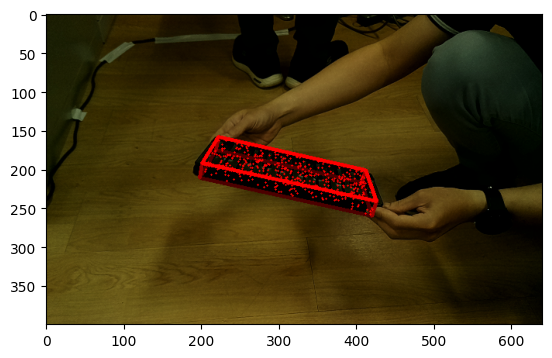

In [17]:
vis_img = draw_detections(img, pred_R[None, ...], pred_t[None, ...]*1000, mesh*1000, k[None, ...])

plt.imshow(vis_img)